# Registration of aliased images

# 1. Theory

**Note.** 
- **Convolution**: $(f*g)(\tau) := \int_{-\infty}^{\infty} f(\tau-t) g(t) dt$
- **Cross-correlation**: $R_{fg}(\tau) = (f \star g)(\tau) := \int_{-\infty}^{\infty} \overline{f(t)} g(t+\tau) dt$
- **Auto-correlation**: $R_{ff}(\tau) = (f \star f)(\tau) := \int_{-\infty}^{\infty} \overline{f(t)} f(t+\tau) dt$

**Property.** 

As $R_{fg}(\tau)=(f \star g)(\tau) = \int_{-\infty}^{\infty}  \overline{f(t-\tau)} g(t) dt$, the cross-correlation is equivalent to the convolution of $\overline{f(-t)}$ and $g(t)$.


## 1.1 Cross-correlation to get the value of the translation

Let's suppose we have two images:
- $f(x,y)$: the original image
- $g(x,y)$: the shifted version of $f$, ie. $g(x,y)=f(x-\Delta x, y - \Delta y )$ 

where $(\Delta x, \Delta y)$ is an unknown translation.


For an image (finite case), the cross-correlation of $f$ and $g$ is defined as:

$$ R_{fg}(u, v) = \sum_{x,y} f(x,y) g(x+u, y+v)$$

It measures how similar $f$ is to a shifted copy of $g$.

By substitution of $g(x,y)=f(x-\Delta x, y - \Delta y )$, we get

$$ R_{fg}(u, v) = \sum_{x,y} f(x,y) f((x+u)-\Delta x, (y+v)-\Delta y)$$

which is exactly the autocorrelation of $f$, evaluated at the shift $(u-\Delta x, v - \Delta y)$.

The autocorrelation of any signal is maximized at zero shift. $R_{fg}(u,v)$ will be maximized at 

$$(u,v) = (\Delta x, \Delta y)$$

## 1.2 Fourier domain view

The convolution theorem states that :

$ \mathcal{F} \{ f * g \} = \mathcal{F}\{ f \}  \cdot \mathcal{F} \{ g \} $


As $ \mathcal{F} \{\overline{f(-t)} \} = \overline{ \mathcal{F} \{ f(t) \}}$, this theorem rewrites for the cross-correlation as $ \mathcal{F} \{ f \star g \} = \overline{ \mathcal{F}\{ f \} } \cdot \mathcal{F} \{ g \} $


Going back to our two shifted images, we note the Fourier transforms of $f$ and $g$ respectively $\mathcal{F}\{ f \} =F $ and $\mathcal{F} \{ g \} = G$. Then,

$ R_{fg} (u,v) = \mathcal{F}^{-1} \{ F(\xi_x, \xi_y) \cdot \overline{G (\xi_x, \xi_y) }\}$

By definition, 

$F(\xi_x, \xi_y)= \int_{x,y} e^{-i (\xi_x x + \xi_y y)} f(x,y) dx dy$ 

and as $g(x,y)=f(x-\Delta x, y - \Delta y)$ then 

$G(\xi_x, \xi_y)= \int_{x,y} e^{-i (\xi_x x + \xi_y y)} f(x-\Delta x,y-\Delta y) dx dy
                = \int_{x,y} e^{-i (\xi_x (x + \Delta x) + \xi_y (y + \Delta y))} f(x,y) dxdy
$

therefore 

$G(\xi_x, \xi_y) = e^{-i(\xi_x \Delta x + \xi_y \Delta y )} F(\xi_x, \xi_y)$ 

A translation in the domain of $(x,y)$ results in a phase change in the domain of Fourier. 


With this in mind we can rewrite our cross-correlation product as :

$F(\xi_x, \xi_y) \cdot \overline{G (\xi_x, \xi_y) } = | F(\xi_x, \xi_y)|^2 e^{i(\xi_x \Delta x + \xi_y \Delta y)} $

The inverse Fourier transform of this is the autocorrelation shifted by $(\Delta x, \Delta y)$. Its peak will give us the translation vector.

# 2. Practical example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from pathlib import Path

In [2]:
data_path = Path.cwd().parent / "images"
u = image.imread(data_path / 'cameraman.pgm').astype('double')

2 cases: 
- integer translation
- subpixel translation

## 2.1 Integer translation

### 2.1.1 Translation

Here `u_1` is shifted of $(z_x, z_y)=(10, 5)$. The shifted image is stored in `u_2`.

In [3]:
z = (10, 5)  # translation vector

u_1 = u[20:140, 70:170]
u_2 = u[20 + z[1] : 140 + z[1], 70 + z[0] : 170 + z[0]]

In [4]:
def get_extent(array):
    return (
    -array.shape[1]//2,
    array.shape[1]//2,
    array.shape[0]//2,
    -array.shape[0]//2
    )

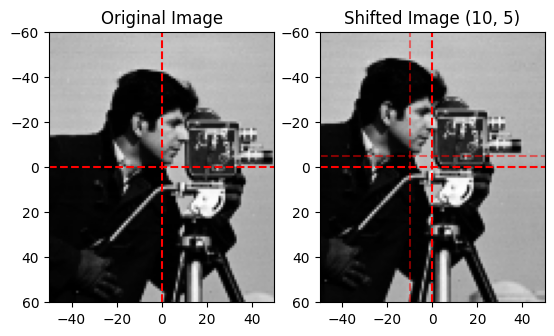

In [5]:
fig, axs = plt.subplots(1, 2)

extent = get_extent(u_1)

axs[0].imshow(u_1, cmap='gray', extent=extent)
axs[1].imshow(u_2, cmap='gray', extent=extent)

axs[0].set_title('Original Image')
axs[1].set_title(f'Shifted Image {z}')

axs[0].axvline(x=0, color='r', linestyle='--')
axs[0].axhline(y=0, color='r', linestyle='--')

axs[1].axvline(x=0, color='r', linestyle='--')
axs[1].axhline(y=0, color='r', linestyle='--')

axs[1].axvline(x=-z[0], color='r', linestyle='--', alpha=0.5)
axs[1].axhline(y=-z[1], color='r', linestyle='--', alpha=0.5)


### 2.1.2 Registration

For two images $u$ and $v$ the cross-correlation is defined as:

$(u \star v)(x,y) = \mathcal{F}^{-1} \{ \mathcal{F}(u) \cdot \overline{\mathcal{F}(v)}\}$

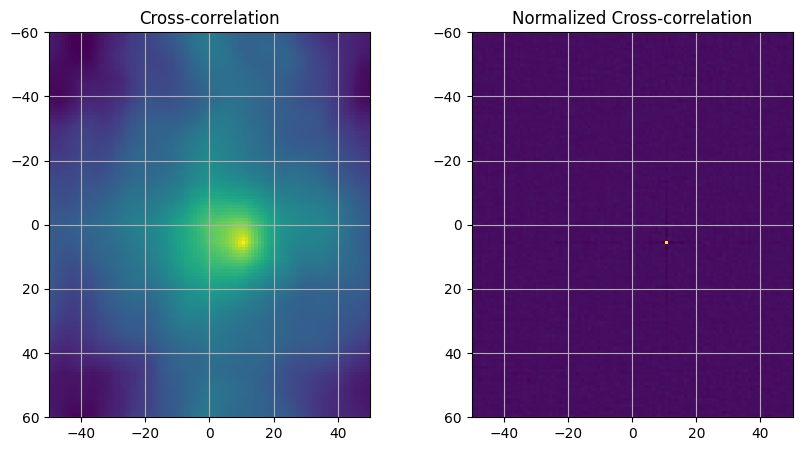

In [6]:
def cross_correlation(u, v, bool_fftshift=True):
    """
    Computes the cross-correlation of two images using Fourier transforms.
    Args:
    - u: First image
    - v: Second image
    """
    U = np.fft.fft2(u)
    V = np.fft.fft2(v)
    image_product = U * V.conj()

    cc_image = np.fft.ifft2(image_product)
    cc_image_normalized = np.fft.ifft2(image_product / np.abs(image_product))

    if bool_fftshift:
        return np.real(np.fft.fftshift(cc_image)), np.real(np.fft.fftshift(cc_image_normalized))
    else:
        return np.real(cc_image), np.real(cc_image_normalized)

cc, cc_norm = cross_correlation(u_1, u_2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cc, extent=extent)
axs[1].imshow(cc_norm, extent=extent)
axs[0].set_title("Cross-correlation")
axs[1].set_title("Normalized Cross-correlation")
axs[0].grid()
axs[1].grid()

In [7]:
y_peak, x_peak = np.unravel_index(np.argmax(cc), cc.shape)

# As we used fftshift, zero displacement is at the center:
dx = x_peak - cc.shape[1] // 2
dy = y_peak - cc.shape[0] // 2

print(f"The translation peak is located at ({dx}, {dy}).")

The translation peak is located at (10, 5).


In [ ]:
def get_integer_translation(cc):
    y_peak, x_peak = np.unravel_index(np.argmax(cc), cc.shape)

    dx = x_peak - cc.shape[1] // 2
    dy = y_peak - cc.shape[0] // 2

    return dx, dy

## 2.2 Subpixel Translation

### 2.2.1 Translation

To translate the image, we can use the Fourier interpolation (cf. section (1.2))

$F_{shifted}(\xi_x, \xi_y) = e^{-i(\xi_x \Delta x + \xi_y \Delta y )} F(\xi_x, \xi_y)$ 

and we can take the inverse Fourier transform to get the shifted image:

$f_{shifted}(x,y) = \mathcal{F}^{-1}(F_{shifted}) $

**Note.** The inverse Fourier transform is complex due to numerical errors, even if the original image is real. In theory the imaginary part should be zero. In practice, small imaginary parts appear due to floating-point errors.


In [9]:
def translation_subpix_fft(u, z):
    """
    Performs 2D subpixel translation of an image using Fourier interpolation.
    Args:
    - u: The original image
    - z: The translation vector (zx, zy)
    """
    zx, zy = z

    ny, nx = u.shape
    fx = np.fft.fftfreq(nx)
    fy = np.fft.fftfreq(ny)

    u_fft = np.fft.fft2(u)

    FX, FY = np.meshgrid(fx, fy)
    phase = np.exp(-2j * np.pi * (FX * zx + FY * zy))
    u_fft_shifted = u_fft * phase

    return np.real(np.fft.ifft2(u_fft_shifted))

Here `u_1` is shifted of $(z_x, z_y)=(10.6, 5.3)$. The shifted image is stored in `u_shifted_fft`.

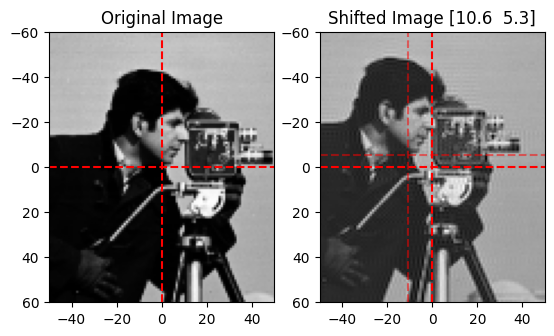

In [10]:
z = np.array([10.6, 5.3])  # translation vector

u_1 = u[20:140, 70:170]
u_shifted_fft = translation_subpix_fft(u, -z)[20:140, 70:170]

extent = get_extent(u_1)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(u_1, cmap='gray', extent=extent)
axs[1].imshow(u_shifted_fft, cmap='gray', extent=extent)

axs[0].set_title('Original Image')
axs[1].set_title(f'Shifted Image {z}')

axs[0].axvline(x=0, color='r', linestyle='--')
axs[0].axhline(y=0, color='r', linestyle='--')

axs[1].axvline(x=0, color='r', linestyle='--')
axs[1].axhline(y=0, color='r', linestyle='--')

axs[1].axvline(x=-z[0], color='r', linestyle='--', alpha=0.5)
axs[1].axhline(y=-z[1], color='r', linestyle='--', alpha=0.5)

**Note.**

To shift the image of a subpixel amount, we used the Fourier interpolation.
 
As we computed the Fourier transform on a finite sampled image, it means that we multiplied the original signal by a rectangular window in space:

$f_{windowed}(x,y) = f(x,y) \cdot \text{rect} \left(  \frac{x}{N} , \frac{y}{N} \right) $

As $\text{sinc} = \mathcal{F}(\text{rect})$, multiplying by a rectangle in time-domain is the same as convolution with a $\text{sinc}$ in frequency-domain. The spectrum got is distorted, causing oscillatory artifacts when getting back the signal to time-domain. We can observe those artifacts in the shifted image as small oscillations around the edges.

### 2.2.2 Registration

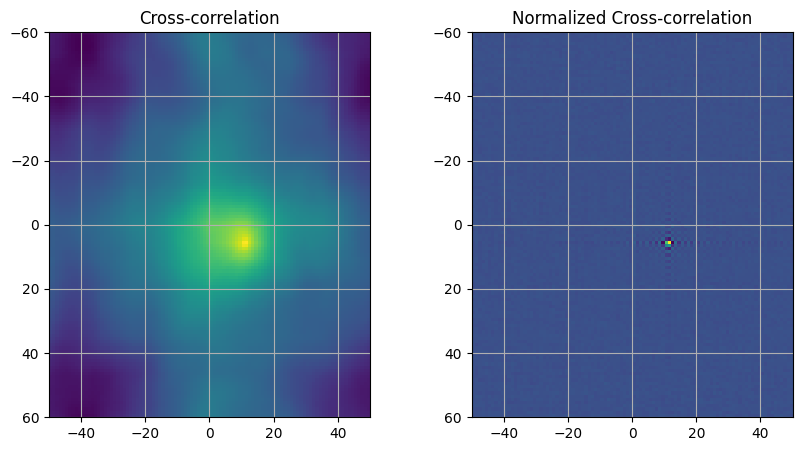

In [11]:
cc, cc_norm = cross_correlation(u_1, u_shifted_fft)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cc, extent=extent)
axs[1].imshow(cc_norm, extent=extent)

axs[0].set_title("Cross-correlation")
axs[1].set_title("Normalized Cross-correlation")

axs[0].grid()
axs[1].grid()

### 2.2.3 Upsampling

Now, let's locate the peak up to subpixel accuracy.

To do so, we are going to use the upsampling technique.
Let $L$ be the upsampling factor,

1. *Expansion*: create a sequence with the original samples separated by $L-1$ zeros 
2. *Interpolation*: smooth out the discontinuities using a lowpass filter, which replaces the zeros

In [12]:
# We use the normalized cross-correlation image:
cc_image = cc_norm

In [13]:
# Expansion step
upsampling_factor = 10
width, height = cc_image.shape[1], cc_image.shape[0]

img_expanded = np.zeros((upsampling_factor * height, upsampling_factor * width))
for i in range(width):
    for j in range(height):
        img_expanded[j * upsampling_factor, i * upsampling_factor] = cc_image[j, i]

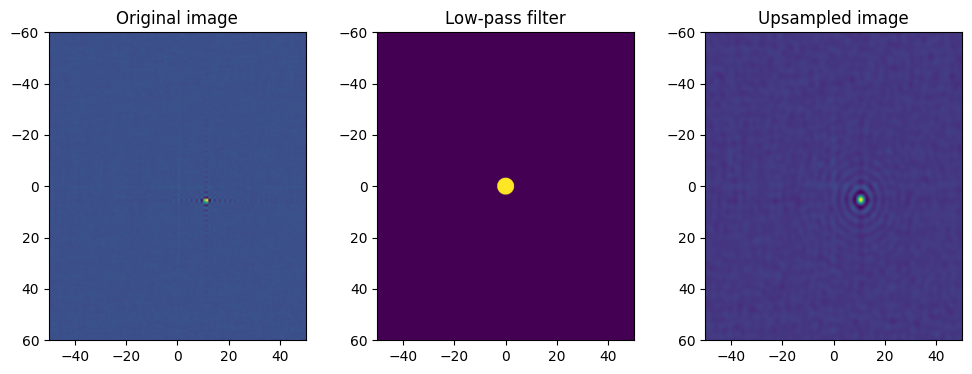

In [14]:
# Low-pass filter
upsampled_height, upsampled_width = np.shape(img_expanded)
D0 = min(upsampled_height, upsampled_width) // 30   # cut-off frequency

fy = np.arange(-upsampled_height//2, upsampled_height//2)
fx = np.arange(-upsampled_width//2, upsampled_width//2)
FY, FX = np.meshgrid(fy, fx, indexing='ij')

D = np.sqrt(FY**2 + FX**2)

H = np.zeros_like(D)
H[D <= D0] = 1

# Filter expanded image using the low-pass filter
F = np.fft.fft2(img_expanded)
F_filtered = F * H

img_interp = np.fft.ifft2(np.fft.ifftshift(F_filtered))
img_interp = np.real(img_interp)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1), plt.title("Original image"), plt.imshow(cc_image, extent=extent)
plt.subplot(1,3,2), plt.title("Low-pass filter"), plt.imshow(H, extent=extent)
plt.subplot(1,3,3), plt.title("Upsampled image"), plt.imshow(img_interp, extent=extent)

plt.show()

In [15]:
# Get the peak in the upsampled image
y_peak, x_peak = np.unravel_index(np.argmax(img_interp), img_interp.shape)

# Correct for zero displacement at the center
dx = x_peak - img_interp.shape[1] // 2
dy = y_peak - img_interp.shape[0] // 2

print(f"The translation peak is located at ({dx/10 :.1f}, {dy/10 :.1f}).")

The translation peak is located at (10.6, 5.3).


In [ ]:
def get_translation_upsampling(cc, upsampling_factor=10):
    width, height = cc.shape[1], cc.shape[0]

    img_expanded = np.zeros((upsampling_factor * height, upsampling_factor * width))
    for i in range(width):
        for j in range(height):
            img_expanded[j * upsampling_factor, i * upsampling_factor] = cc[j, i]


    # Low-pass filter
    upsampled_height, upsampled_width = np.shape(img_expanded)
    D0 = min(upsampled_height, upsampled_width) // 30   # cut-off frequency

    fy = np.arange(-upsampled_height//2, upsampled_height//2)
    fx = np.arange(-upsampled_width//2, upsampled_width//2)
    FY, FX = np.meshgrid(fy, fx, indexing='ij')

    D = np.sqrt(FY**2 + FX**2)

    H = np.zeros_like(D)
    H[D <= D0] = 1

    # Filter expanded image using the low-pass filter
    F = np.fft.fft2(img_expanded)
    F_filtered = F * H

    img_interp = np.fft.ifft2(np.fft.ifftshift(F_filtered))
    img_interp = np.real(img_interp)

    # Get the peak in the upsampled image
    y_peak, x_peak = np.unravel_index(np.argmax(img_interp), img_interp.shape)
    dx = x_peak - img_interp.shape[1] // 2
    dy = y_peak - img_interp.shape[0] // 2

    return dx/upsampling_factor, dy/upsampling_factor


# 3. Using aliased images

## 3.1 Translate & aliase the images

In [17]:
aliasing_factor = 2

z = (5, 2)  # translation vector
z_subpix = np.array([5.3, 2.6])

u_original = u[::aliasing_factor, ::aliasing_factor]
u_cropped = u_original[10:70, 35:85]
u_2 = u_original[10 + z[1] : 70 + z[1], 35 + z[0] : 85 + z[0]]
u_subpix_2 = translation_subpix_fft(u_original, -z_subpix)[10:70, 35:85]

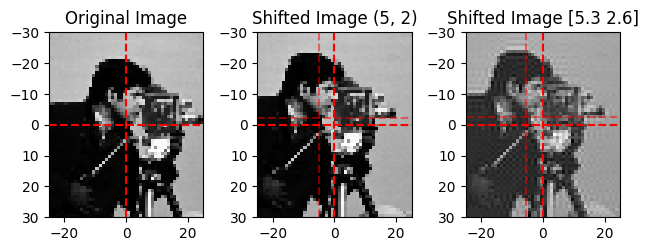

In [18]:
extent = get_extent(u_cropped)

fig, axs = plt.subplots(1, 3)

axs[0].imshow(u_cropped, cmap='gray', extent=extent)
axs[1].imshow(u_2, cmap='gray', extent=extent)
axs[2].imshow(u_subpix_2, cmap='gray', extent=extent)

axs[0].set_title('Original Image')
axs[1].set_title(f'Shifted Image {z}')
axs[2].set_title(f'Shifted Image {z_subpix}')

axs[0].axvline(x=0, color='r', linestyle='--')
axs[0].axhline(y=0, color='r', linestyle='--')

axs[1].axvline(x=0, color='r', linestyle='--')
axs[1].axhline(y=0, color='r', linestyle='--')

axs[2].axvline(x=0, color='r', linestyle='--')
axs[2].axhline(y=0, color='r', linestyle='--')

axs[1].axvline(x=-z[0], color='r', linestyle='--', alpha=0.5)
axs[1].axhline(y=-z[1], color='r', linestyle='--', alpha=0.5)

axs[2].axvline(x=-z_subpix[0], color='r', linestyle='--', alpha=0.5)
axs[2].axhline(y=-z_subpix[1], color='r', linestyle='--', alpha=0.5)

plt.tight_layout()

## 3.2 Registration of the aliased images

In [19]:
cc_image = cross_correlation(u_cropped, u_2)[1]
dx, dy = get_integer_translation(cc_image)

print(f"The translation peak is located at ({dx}, {dy}).")

The translation peak is located at (5, 2).


In [20]:
cc_image = cross_correlation(u_cropped, u_subpix_2)[1]
dx, dy = get_translation_upsampling(cc_image)

print(f"The translation peak is located at ({dx}, {dy}).")

The translation peak is located at (5.3, 2.6).
